<a href="https://colab.research.google.com/github/gwijthoff/HTRC_SF_experiments/blob/main/htrc_sf_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of HTRC data

HTRC provides a number of [specialized worksets](https://analytics.hathitrust.org/staticrecommendedworksets): topic-based collections of books (or "volumes") digitized by HathiTrust. Here, we'll be working with David Mimno and Laure Thompson's **20th Century English-Language Speculative Fiction** workset. It contains 2,454 "volumes of speculative fiction [from 1900-1999] identified both through matching titles and authors to [Worlds Without End](https://www.worldswithoutend.com/) (WWE), an extensive fan-built database of speculative fiction, and via computational text similarity analysis techniques."

The [HTRC Analytics interface](https://analytics.hathitrust.org) provides a few different, pre-defined ways of analyzing and accessing the data in their Recommended Worksets. I have already pre-downloaded all of the files needed for this tutorial and included them in this repository. So, if it's speculative fiction you want to work with, feel free to move on to the tutorial's [next section](#Working-with-metadata-for-entire-SF-workset). Otherwise, if you would like to use a different workset or learn the steps I took to get these files, continue reading below the line.

***********

**Optional:** to access the HTRC workset, navigate to <https://analytics.hathitrust.org/worksets> and log in or create an account. Select the workset you want, then click the orange download button. This will give you `20th Century English-Language Speculative Fiction-htrc.csv`, a CSV that contains the HathiTrust ID and title for each volume in the workset.

You can also download pre-processed analyses of the texts in the workset, including:

- **Named Entity Recognition**: click the "Analysis" dropdown menu and select Named Entity Recognizer to download `entities.csv`, which identifies particular words (or "tokens) in the workset as being people, organizations, or places
- **Token Counts**: select "Token Counts and Tag Cloud Creator" in the dropdown to download `token_counts.csv`: raw counts of every token in the workset's 2,454 volumes

But we'll primarily be working with **Extracted Features**: a data format developed by HTRC that provides quantitative information describing every page of every volume in the collection. Each file is a compressed JSON. The files allow for nonconsumptive use of post 1923 works by providing "quantitative abstractions of a book’s written content" and metadata about each book.

You need to use `rsync` to download these Extracted Features files for the entire SF workset. Again, *I've already done so and downloaded all of the Extracted Features data into the [`data/SpecFic_extracted_features`](https://github.com/gwijthoff/HTRC_SF_experiments/tree/main/data/SpecFic_extracted_features) directory of this repo.* But for future reference, here are the full [instructions for doing so](https://analytics.hathitrust.org/algorithms/Extracted_Features_Download_Helper?wsname=20th+Century+English-Language+Speculative+Fiction%40htrc). That process generates a shell script, `EF_Rsync.sh`. Once downloaded and run, that script will download the Extracted Features files for all 2,454 of those volumes. As we'll see in a bit, those files are stored in a tricky pairtree file/folder format.

# Working with metadata for entire SF workset

First, we'll read in the CSV file containing bibliographic information on the SF workset as a [Pandas](https://pandas.pydata.org/) dataframe.

**Note:** All the relevant files for this tutorial are located in this repo's [`/data`](https://github.com/gwijthoff/HTRC_SF_experiments/tree/main/data) directory, and are referenced throughout the notebook using that directory slug. *If you choose to use Google Colab* to run this notebook (rather than, for example, downloading and running it locally using [Anaconda](https://www.anaconda.com/products/individual)), you will need to change the file locations to the URL hosted on GitHub. For example, in the code block below,

`data/20th Century English-Language Speculative Fiction-htrc.csv`

would become

`https://raw.githubusercontent.com/gwijthoff/HTRC_SF_experiments/main/data/20th%20Century%20English-Language%20Speculative%20Fiction-htrc.csv`

In [6]:
import pandas as pd

# select the CSV hosted by GitHub
sfhtrc_csv = "data/20th Century English-Language Speculative Fiction-htrc.csv"

# read that CSV as a pandas dataframe
sf_biblio = pd.read_csv(sfhtrc_csv, delimiter=",", encoding='utf-8')
sf_biblio

,id,title,year,language,authors
0,mdp.39015028685199,The Alien condition. Edited by Stephen Goldin.,1973,eng,"Goldin, Stephen"
1,mdp.39015046479799,The sea came in at midnight / Steve Erickson.,1999,eng,"Erickson, Steve"
2,mdp.39015005649820,Plague ship / by Andre Norton.,1978,eng,"Norton, Andre"
3,mdp.39015011695874,The time traders / Andre Norton.,1978,eng,"Norton, Andre"
4,mdp.39015011358150,Blue Adept / Piers Anthony ; [map by Chris Bar...,1981,eng,"Anthony, Piers"
...,...,...,...,...,...
2449,mdp.39015000146798,The wind's twelve quarters : short stories / b...,1975,eng,"Le Guin, Ursula K. 1929-"
2450,mdp.39015034647167,Doorways in the sand / Roger Zelazny.,1977,eng,"Zelazny, Roger"
2451,nyp.33433105944254,"A modern Utopia, by H. G. Wells.",1905,eng,"Wells, H. G. (Herbert George) 1866-1946; Sulli..."
2452,nnc1.cu16181638,The castle of iron :\na science fantasy adventure,1962,NaN,"De Camp, L. Sprague 1907-2000"


In [7]:
# some numbers in the year column are floats (contain a decimal)
# convert those years to integers / whole numbers
sf_biblio['year'] = sf_biblio['year'].astype('int64')

# becuase everything in this workset is in English
# for simplicity's sake, we'll drop the language column
sf_biblio = sf_biblio.drop(columns="language")

# HTRC Extracted Features files use the variable name `vol_id` for HathiTrust IDs
# but the bibliographic info CSV uses `id`
# so, rename that column to match the Extracted Features we'll be working with
sf_biblio = sf_biblio.rename(columns = {'id':'vol_id'})

# sample ten volumes from the dataframe to verify our results
sf_biblio.sample(10)

,vol_id,title,year,authors
1487,mdp.39015005091841,Voodoo planet and Star hunter / by Andre Norton.,1978,"Norton, Andre"
639,mdp.39015062115905,Virtual light / William Gibson.,1993,"Gibson, William 1948-"
248,uc1.32106010566989,"Job, a comedy of justice / Robert A. Heinlein.",1984,"Heinlein, Robert A. (Robert Anson) 1907-1988"
2389,osu.32435059729889,SF: '57 : the year's greatest science fiction ...,1957,"Merril, Judith 1923-1997"
1019,uva.x000133437,The iron thorn.,1968,"Budrys, Algis 1931-2008"
1195,mdp.39015061469303,Clicking stones / by Nancy Tyler Glenn.,1989,"Glenn, Nancy Tyler 1938-"
2272,mdp.39015002652942,Orsinian tales / Ursula K. Le Guin.,1976,"Le Guin, Ursula K. 1929-"
1296,inu.32000009095367,The Victorian chaise-longue.,1953,"Laski, Marghanita 1915-"
96,uva.x000884414,Sword of the lamb / M.K. Wren.,1981,"Wren, M. K"
2078,mdp.39015034397789,The Bellmaker / Brian Jacques ; illustrated by...,1995,"Jacques, Brian; Curless, Allan ill"


We now have a structured DataFrame that contains the HTRC volume ID, the title of the volume, its publication year, and its author.

But there are many other data fields in the Extracted Features and named entity recognition data that we'll want to work with. So, let's merge this DataFrame with those other datasets.

# Get the pairtree path for all volumes

`rsync` downloads all Extracted Features files in a convoluted pairtree folder format. For example, the data file for a novel at the HTRC url <http://hdl.handle.net/2027/mdp.39015028685199> will be downloaded via rsync in the directory structure `mdp/31289/mdp.39015028685199.json.bz2`. To get a sense of these tangled and nested directories, browse the Extracted Features files [in this folder](https://github.com/gwijthoff/HTRC_SF_experiments/tree/main/data/SpecFic_extracted_features).

We can use one of the utilities in HTRC's Feature Reader to reconstruct the pairtree paths. First, let's install Feature Reader, which we'll use later to explore the Extracted Features files.

In [8]:
# install the HTRC Feature Reader
! pip install htrc-feature-reader

Now, let's use the `htid2rsync` utility. From the [documentation](https://github.com/htrc/htrc-feature-reader/blob/master/examples/ID_to_Rsync_Link.ipynb):

> When you install the HTRC Feature Reader, a command line utility is installed, `htid2rsync`, which converts one or more volume ids to paths in the rsync pairtree. . . . Loading volume ids from a file: If you have a file of volume ids, one per line, use --from-file filename, or just -f filename.

In order to reconstruct the filepaths for each volume, we can use the HTRC volume IDs column in `data/20th Century English-Language Speculative Fiction-htrc.csv` used above. I created a text file with a list of those HTRC IDs, one on each line: `data/sf_ids.txt`. [There's probably a pythonic way of doing this, but I felt lazy and just manually copy-pasted.] We'll use that .txt file to convert HTRC IDs to local pairtree paths.

So, this shell command will take each HTRC ID in `sf_ids.txt`, one volume per line, and convert them to the pairtree directory of each volume's associated Extracted Features file in a new file, `paths.txt`.

In [9]:
! htid2rsync --f data/sf_ids.txt -o data/paths.txt

# Merging pairtree paths with bibliographic DataFrame

Now we need to create two lists from those .txt files, one for HTRC IDs and another for pairtree paths. Let's begin with the one for paths:

In [10]:
from htrc_features import FeatureReader

#  create a list from paths.txt line by line
path_file = open('data/paths.txt')
list1 = path_file.readlines()
items = []
for i in list1:
    items.append(i)

# remove the \n character from that list
list2 = [x[:-1] for x in items]

# add home directory slugs
dir = 'data/SpecFic_extracted_features/'
paths = [dir + x for x in list2]

# view the first 10 items in the list
paths[:10]

['data/SpecFic_extracted_features/mdp/31289/mdp.39015028685199.json.bz2',
 'data/SpecFic_extracted_features/mdp/31479/mdp.39015046479799.json.bz2',
 'data/SpecFic_extracted_features/mdp/31042/mdp.39015005649820.json.bz2',
 'data/SpecFic_extracted_features/mdp/31197/mdp.39015011695874.json.bz2',
 'data/SpecFic_extracted_features/mdp/31155/mdp.39015011358150.json.bz2',
 'data/SpecFic_extracted_features/uva/x019/uva.x000221509.json.bz2',
 'data/SpecFic_extracted_features/uc1/30038/uc1.32106006839184.json.bz2',
 'data/SpecFic_extracted_features/coo1/a+30226/coo1.ark+=13960=t2z32cn6s.json.bz2',
 'data/SpecFic_extracted_features/mdp/31021/mdp.39015008521117.json.bz2',
 'data/SpecFic_extracted_features/mdp/31049/mdp.39015000543895.json.bz2']

And now we'll create another list for the HTRC IDs:

In [11]:
#  create a list from sf_ids.txt line by line
id_file = open('data/sf_ids.txt')
listids = id_file.readlines()
items = []
for i in listids:
    items.append(i)

# remove the \n character from that list
ids = [x[:-1] for x in items]

# view the first 10 items in the list
ids[:10]

['mdp.39015028685199',
 'mdp.39015046479799',
 'mdp.39015005649820',
 'mdp.39015011695874',
 'mdp.39015011358150',
 'uva.x000221509',
 'uc1.32106006839184',
 'coo1.ark:/13960/t2z32cn6s',
 'mdp.39015008521117',
 'mdp.39015000543895']

Now let's zip those two lists together as a list of tuples, and create a DataFrame out of it. The numbers in the HathiTrust ID and the directory location of the Extracted Features json for that volume should match up.

In [12]:
id_tuples = list(zip(ids, paths))
id_tuples[:10] 

[('mdp.39015028685199',
  'data/SpecFic_extracted_features/mdp/31289/mdp.39015028685199.json.bz2'),
 ('mdp.39015046479799',
  'data/SpecFic_extracted_features/mdp/31479/mdp.39015046479799.json.bz2'),
 ('mdp.39015005649820',
  'data/SpecFic_extracted_features/mdp/31042/mdp.39015005649820.json.bz2'),
 ('mdp.39015011695874',
  'data/SpecFic_extracted_features/mdp/31197/mdp.39015011695874.json.bz2'),
 ('mdp.39015011358150',
  'data/SpecFic_extracted_features/mdp/31155/mdp.39015011358150.json.bz2'),
 ('uva.x000221509',
  'data/SpecFic_extracted_features/uva/x019/uva.x000221509.json.bz2'),
 ('uc1.32106006839184',
  'data/SpecFic_extracted_features/uc1/30038/uc1.32106006839184.json.bz2'),
 ('coo1.ark:/13960/t2z32cn6s',
  'data/SpecFic_extracted_features/coo1/a+30226/coo1.ark+=13960=t2z32cn6s.json.bz2'),
 ('mdp.39015008521117',
  'data/SpecFic_extracted_features/mdp/31021/mdp.39015008521117.json.bz2'),
 ('mdp.39015000543895',
  'data/SpecFic_extracted_features/mdp/31049/mdp.39015000543895.json

Now create a new DataFrame and randomly sample 5 items.

In [13]:
dfid = pd.DataFrame(id_tuples, columns = ['vol_id', 'path'])
dfid.sample(5)

,vol_id,path
2303,mdp.39015047112498,data/SpecFic_extracted_features/mdp/31419/mdp....
414,wu.89014640072,data/SpecFic_extracted_features/wu/8147/wu.890...
1155,mdp.39015008979794,data/SpecFic_extracted_features/mdp/31079/mdp....
665,mdp.39015047473528,data/SpecFic_extracted_features/mdp/31472/mdp....
805,uc1.32106002192786,data/SpecFic_extracted_features/uc1/30098/uc1....


And finally, merge that new DataFrame with our existing `sf_biblio` DataFrame, matching them up using the `vol_id` column.

In [14]:
bibloc = pd.merge(sf_biblio, dfid, on='vol_id')
# replace all NaN values with a blank cell (??)
bibloc.fillna('',inplace=True)
bibloc.sample(5)

,vol_id,title,year,authors,path
457,mdp.39015034424724,Mercury / Anna Kavan ; with a foreword by Dori...,1994,"Kavan, Anna 1901-1968",data/SpecFic_extracted_features/mdp/31322/mdp....
280,mdp.39015022255817,Boy's life / Robert R. McCammon.,1991,"McCammon, Robert R",data/SpecFic_extracted_features/mdp/31251/mdp....
943,uva.x001298418,The ark Sakura / Kobo Abe ; [translated by Jul...,1988,"Abe, Ko?bo? 1924-1993",data/SpecFic_extracted_features/uva/x188/uva.x...
1899,pst.000049761221,The realms of the gods / Tamora Pierce.,1996,"Pierce, Tamora",data/SpecFic_extracted_features/pst/0072/pst.0...
2424,mdp.39015031213609,The wrong end of time / by John Brunner.,1971,"Brunner, John 1934-1995",data/SpecFic_extracted_features/mdp/31310/mdp....


# Using our new bibliographic dataframe to query Extracted Features

We can now use this DataFrame containing bibliographic and file path info to query Extracted Features data on each book.

Let's filter the author column to all volumes containing the string "Delany," to find works included in this workset written by Samuel R. Delany.

In [16]:
bibloc[bibloc['authors'].str.contains('Delany')]

,vol_id,title,year,authors,path
277,mdp.39015008955943,"Driftglass, by Samuel R. Delaney [i.e. Delany]",1971,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31054/mdp....
328,mdp.39015014574118,The bridge of lost desire / Samuel R. Delany.,1987,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31171/mdp....
378,mdp.39015005320745,Babel-17 / Samuel R. Delany ; with a new intro...,1976,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31024/mdp....
495,osu.32435058033408,The jewels of Aptor / Samuel R. Delany. The se...,1962,"Delany, Samuel R; White, James",data/SpecFic_extracted_features/osu/33530/osu....
646,mdp.39015008420773,The fall of the towers / Samuel R. Delany ; wi...,1977,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31027/mdp....
670,uc1.32106008842756,Triton / Samuel R. Delany.,1976,"Delany, Samuel R",data/SpecFic_extracted_features/uc1/30045/uc1....
765,mdp.39015008600119,Stars in my pocket like grains of sand / Samue...,1984,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31001/mdp....
804,mdp.39015046879170,Flight from Nev?r?on / Samuel R. Delany.,1985,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31477/mdp....
877,mdp.39015016440722,The ballad of Beta-2 / by Samuel R. Delany.,1965,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31142/mdp....
1217,mdp.39015012119213,Tales of Neveryon. By S. Delany.,1979,"Delany, Samuel R",data/SpecFic_extracted_features/mdp/31111/mdp....


Now we can use the dataframe index (number in the leftmost column) to select a volume's filepath and interact with its Extracted Features data. To explore Delany's classic *Triton* (first published as *Trouble on Triton*), we'll use `iloc` to select a cell at row 670 and column 4 (counting over from the left beginning at 0).

In [17]:
tritonPath = bibloc.iloc[670, 4]
tritonPath

'data/SpecFic_extracted_features/uc1/30045/uc1.32106008842756.json.bz2'

Now that we have that local pairtree path, we can access the Extracted Features data for that volume using HTRC's Feature Reader.

In [18]:
from htrc_features import Volume
vol = Volume(tritonPath)
vol

And we can interact with the Extracted Features in many ways. For example:

In [26]:
# pull various metadata fields and insert them into a string of text
print(f'There are {vol.page_count}pp. in {vol.title}, which was published in {vol.pub_place} and can be identified by OCLC number {vol.oclc}.')
print(f'This copy of {vol.title} was originally digitized at {vol.source_institution}.')

There are 396pp. in Triton /, which was published in New York (State) and can be identified by OCLC number 2084794.
This copy of Triton / was originally digitized at UCSC.


In [27]:
# view a list of all metadata fields available for this volume
vol.parser.meta.keys()

dict_keys(['id', 'metadata_schema_version', 'enumeration_chronology', 'type_of_resource', 'title', 'date_created', 'pub_date', 'language', 'access_profile', 'isbn', 'issn', 'lccn', 'oclc', 'page_count', 'feature_schema_version', 'access_rights', 'alternate_title', 'category', 'genre_ld', 'genre', 'contributor_ld', 'contributor', 'handle_url', 'source_institution_ld', 'source_institution', 'lcc', 'type', 'is_part_of', 'last_rights_update_date', 'pub_place_ld', 'pub_place', 'main_entity_of_page', 'publisher_ld', 'publisher'])

To view the values for any of those fields, simply enter `vol.FIELD`. For example:

In [25]:
vol.last_rights_update_date

20190208

In [28]:
# count the number of tokens per page
tokenspp = vol.tokens_per_page()
tokenspp.head()

page
2    39
3    17
4     1
5    16
6    87
Name: tokenCount, dtype: int64

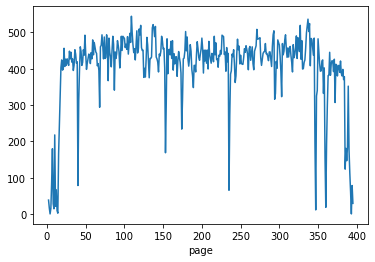

In [29]:
# graph the count of tokens per page over the course of the book
tokenspp.plot()

Return details on each token's part of speech (represented by the [Penn Tree Bank](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) for English), number of times it appears in the book, and the section it appears in the book.

In [31]:
tl = vol.tokenlist()
tl.sample(10)

,,,,count
page,section,token,pos,
129,body,my,PRP$,1
243,body,out,IN,2
362,body,only,RB,1
345,body,no,DT,1
291,body,Mars,NNP,1
349,body,different,JJ,1
32,body,deserves,VBZ,1
109,body,before,IN,1
316,body,eohippos,NNS,1


In [34]:
# create a list of all the unique tokens / words in the book
words = vol.tokens()
# count those words / measure size of the book's vocabulary
print(len(words))

12208


In [35]:
# view other section features, counting number of tokens, 
# lines, and sentences on each page of the book
features = vol.section_features()
features[100:110]

,tokenCount,lineCount,emptyLineCount,capAlphaSeq,sentenceCount
page,,,,,
103,453,41,0,4,25.0
104,488,42,0,3,35.0
105,440,42,0,3,28.0
106,467,42,0,3,35.0
107,497,42,0,3,44.0
108,472,40,0,2,29.0
109,544,42,0,2,40.0
110,499,43,0,3,30.0
111,466,42,0,0,22.0


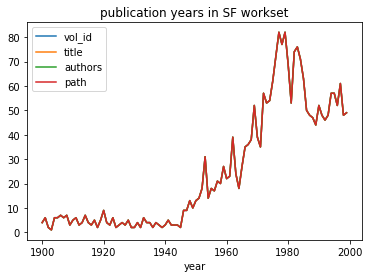

In [36]:
# see the distribution of publication years for books in the entire SF workset
# OBVIOUSLY NOT THE RIGHT WAY TO DO THIS
bibloc.groupby('year').count().plot.line(title='publication years in SF workset')

# What's next

Check out these tutorials for more examples of how to work with Extracted Features data and HTRC's Feature Reader.

- [README.ipynb](https://github.com/htrc/htrc-feature-reader/blob/master/README.ipynb) from the HTRC github documentation
- [Text Mining in Python through the HTRC Feature Reader](https://programminghistorian.org/en/lessons/text-mining-with-extracted-features) from the *Programming Historian*
- [Analyzing Documents with TF-IDF](https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf) at the *Programming Historian* also uses HTRC Extracted Features
- visualize the rise and fall of topic models across a book with [htrc-book-models](https://github.com/organisciak/htrc-book-models)